In [60]:
import numpy as np
import pandas as pd

In [62]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) 

In [63]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [64]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [65]:
#define columns
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [66]:
train_set.columns = col_labels
test_set.columns = col_labels

In [67]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [68]:
#drop rows haveing ? data in column values
train_set.replace(' ?', np.nan).dropna().shape

(30162, 15)

In [69]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [70]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

In [71]:
test_nomissing['wage_class']=test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [72]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [73]:
# need to convert categorical data to numeric
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [74]:
for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [75]:
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

In [76]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [77]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [78]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [79]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [80]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [81]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping

In [82]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
458,0.129898,0.005536,0.116521,0.000994
459,0.129965,0.005315,0.116446,0.000983
460,0.129832,0.005425,0.116455,0.000975
461,0.129500,0.005550,0.116338,0.000941
462,0.129434,0.005663,0.116338,0.000875


In [83]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

In [84]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

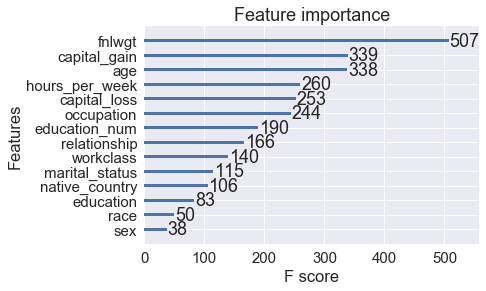

In [85]:
xgb.plot_importance(final_gb)

In [86]:
importances = final_gb.get_fscore()
importances

{'age': 338,
 'capital_gain': 339,
 'capital_loss': 253,
 'education': 83,
 'education_num': 190,
 'fnlwgt': 507,
 'hours_per_week': 260,
 'marital_status': 115,
 'native_country': 106,
 'occupation': 244,
 'race': 50,
 'relationship': 166,
 'sex': 38,
 'workclass': 140}

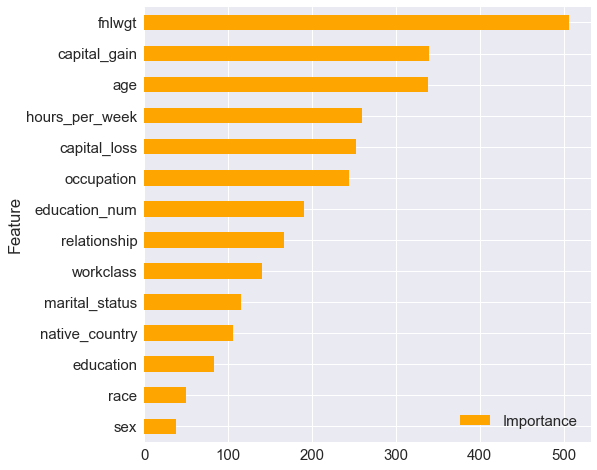

In [87]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [88]:
testdmat = xgb.DMatrix(final_test)

In [89]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([0.00303194, 0.2071426 , 0.3024281 , ..., 0.8288712 , 0.16432679,
       0.7885478 ], dtype=float32)

In [90]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [91]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8686586985391767, 0.13134130146082335)